# Preprocesing dat

# Resampling, trimming and normalization
- Následující kód očekává data ve stupu .flac souborů rozlišených rozdělených do složek dle class
- Každý flac file je resamplován na sample_rate 44100, trimován na 8s a normalizován na interval [0,1]
- Z každého takto připraveného souboru je vytvořen melův spectogram požadovaných rozměrů (128x128, 256x256)

In [75]:
import os
import numpy as np
import torch
import torchaudio
from scipy.ndimage import zoom

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


def resample_audio_torchaudio(input_file, target_sample_rate=44100):
    """
    Resample an audio file to the target sampling rate using torchaudio on GPU.

    Parameters:
        input_file (str): Path to the input audio file.
        target_sample_rate (int): Desired sampling rate.

    Returns:
        torch.Tensor: Resampled audio signal (on GPU).
        int: Resampled sample rate.
    """
    # Load audio file and move to GPU
    waveform, sample_rate = torchaudio.load(input_file)
    waveform = waveform.to(device)

    # Resample if needed
    if sample_rate != target_sample_rate:
        print(f"Resampling {os.path.basename(input_file)} from {sample_rate} Hz to {target_sample_rate} Hz")
        resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=target_sample_rate).to(device)
        waveform = resampler(waveform)
        sample_rate = target_sample_rate

    # Convert to mono if needed
    if waveform.shape[0] > 1:
        waveform = torch.mean(waveform, dim=0, keepdim=True)  # Averaging channels

    return waveform.squeeze(0), sample_rate


def trim_audio(data, sample_rate, target_duration=8.0):
    """
    Trim or skip audio data based on target duration.

    Parameters:
        data (torch.Tensor): Audio data.
        sample_rate (int): Sampling rate of the audio signal.
        target_duration (float): Desired duration in seconds.

    Returns:
        torch.Tensor: Trimmed audio signal of fixed length.
        bool: Whether the file is valid (not too short).
    """
    target_length = int(target_duration * sample_rate)
    
    # Skip files that are shorter than the target length
    if len(data) < target_length:
        print(f"Skipping file (too short): length={len(data) / sample_rate:.2f}s")
        return None, False

    # Trim to the target length
    trimmed_audio = data[:target_length]
    return trimmed_audio, True


def normalize_spectrogram(spectrogram):
    """
    Normalize spectrogram to the range [0, 1] using Min-Max normalization.

    Parameters:
        spectrogram (np.ndarray): Input spectrogram.

    Returns:
        np.ndarray: Normalized spectrogram.
    """
    return (spectrogram - spectrogram.min()) / (spectrogram.max() - spectrogram.min())


def generate_mel_spectrogram(data, sample_rate, output_size=(128, 128)):
    """
    Generate a mel spectrogram from an audio signal using torchaudio on GPU.

    Parameters:
        data (torch.Tensor): Audio data (on GPU).
        sample_rate (int): Sampling rate of the audio signal.
        output_size (tuple): Desired output size (height, width).

    Returns:
        np.ndarray: Resized and normalized mel spectrogram.
    """
    # Generate mel spectrogram on GPU
    mel_spectrogram = torchaudio.transforms.MelSpectrogram(
        sample_rate=sample_rate, n_mels=128, f_max=22000
    ).to(device)(data)

    # Convert to logarithmic scale
    spectrogram_image = torch.log1p(mel_spectrogram).cpu().numpy()

    # Normalize spectrogram to [0, 1]
    spectrogram_image_normalized = normalize_spectrogram(spectrogram_image)

    # Resize the spectrogram using interpolation
    zoom_factors = (output_size[0] / spectrogram_image_normalized.shape[0],
                    output_size[1] / spectrogram_image_normalized.shape[1])
    spectrogram_image_resized = zoom(spectrogram_image_normalized, zoom_factors, order=2)  # Bicubic interpolation
    return spectrogram_image_resized


def process_flac_files(input_root, output_root, output_size=(256, 256), target_sample_rate=44100, target_duration=8.0):
    """
    Process .flac files to generate mel spectrograms and save them in .npy format.

    Parameters:
        input_root (str): Root folder of input audio files (data/class/file.flac).
        output_root (str): Root folder to save spectrograms (spects/class/file.npy).
        output_size (tuple): Size of the generated spectrogram.
        target_sample_rate (int): Sampling rate to resample all audio files to.
        target_duration (float): Target duration in seconds (files shorter are skipped).
    """
    # Walk through the input directory structure
    for root, _, files in os.walk(input_root):
        for file in files:
            if file.endswith('.flac'):
                # Full path to input file
                input_file_path = os.path.join(root, file)

                # Generate relative path to maintain folder structure
                relative_path = os.path.relpath(root, input_root)
                output_dir = os.path.join(output_root, relative_path)

                # Create output directory if it doesn't exist
                os.makedirs(output_dir, exist_ok=True)

                try:
                    # Resample the audio using torchaudio on GPU
                    data, sample_rate = resample_audio_torchaudio(input_file_path, target_sample_rate)

                    # Trim audio to the target duration
                    data, valid = trim_audio(data, sample_rate, target_duration)
                    if not valid:
                        continue  # Skip files shorter than the target duration

                    # Generate the mel spectrogram
                    spectrogram_image = generate_mel_spectrogram(data, sample_rate, output_size)

                    # Save the spectrogram as .npy
                    output_file_path = os.path.join(output_dir, file.replace('.flac', '.npy'))
                    np.save(output_file_path, spectrogram_image)
                    print(f"Saved: {output_file_path}")

                except Exception as e:
                    print(f"Error processing {input_file_path}: {e}")


if __name__ == "__main__":
    # Define input and output directories
    input_root = "../data/data_audio"      # Path to input folder
    output_root = "../spects_trimmed_256"  # Path to save spectrograms

    # Process all .flac files: 8 seconds trimmed, resampled to 44100 Hz
    process_flac_files(input_root, output_root, output_size=(256, 256), target_sample_rate=44100, target_duration=8.0)


Using device: cpu
Resampling 1sI6qQiU388.flac from 48000 Hz to 44100 Hz
Saved: ../spects_trimmed_256/music/1sI6qQiU388.npy
Resampling HAFw1xZ75sY.flac from 48000 Hz to 44100 Hz
Saved: ../spects_trimmed_256/music/HAFw1xZ75sY.npy
Resampling -FriXMGnBGc.flac from 48000 Hz to 44100 Hz
Saved: ../spects_trimmed_256/music/-FriXMGnBGc.npy
Saved: ../spects_trimmed_256/music/ZtaP6Au1CM0.npy
Resampling N70fARL0mjA.flac from 48000 Hz to 44100 Hz
Saved: ../spects_trimmed_256/music/N70fARL0mjA.npy
Resampling A7Uhrts5fjo.flac from 48000 Hz to 44100 Hz
Saved: ../spects_trimmed_256/music/A7Uhrts5fjo.npy
Resampling 3eWOC5pWwZI.flac from 48000 Hz to 44100 Hz
Saved: ../spects_trimmed_256/music/3eWOC5pWwZI.npy
Saved: ../spects_trimmed_256/music/4ZIwBD3czfc.npy
Saved: ../spects_trimmed_256/music/HC4xYVQ7vqY.npy
Resampling xeIHosUdHcI.flac from 48000 Hz to 44100 Hz
Saved: ../spects_trimmed_256/music/xeIHosUdHcI.npy
Resampling ZP02J8_xDsE.flac from 48000 Hz to 44100 Hz
Saved: ../spects_trimmed_256/music/ZP02J

/var/folders/s9/_9p4z3817rd57lwmdxvh21yw0000gn/T/ipykernel_1419/3026063829.py:77: RuntimeWarning: invalid value encountered in divide
  return (spectrogram - spectrogram.min()) / (spectrogram.max() - spectrogram.min())


Resampling pBtYh8RPM7o.flac from 48000 Hz to 44100 Hz
Saved: ../spects_trimmed_256/music/pBtYh8RPM7o.npy
Saved: ../spects_trimmed_256/music/5WSDnMXl6U8.npy
Resampling aHMUvBprdSY.flac from 48000 Hz to 44100 Hz
Saved: ../spects_trimmed_256/music/aHMUvBprdSY.npy
Resampling 16kBCPEdvKA.flac from 48000 Hz to 44100 Hz
Saved: ../spects_trimmed_256/music/16kBCPEdvKA.npy
Saved: ../spects_trimmed_256/music/BQziZehGRP4.npy
Saved: ../spects_trimmed_256/music/2q1gaKykjnQ.npy
Saved: ../spects_trimmed_256/music/TZCDB7_9VFw.npy
Resampling nzy-M--mNOI.flac from 48000 Hz to 44100 Hz
Saved: ../spects_trimmed_256/music/nzy-M--mNOI.npy
Saved: ../spects_trimmed_256/music/2BMsMryjSNo.npy
Saved: ../spects_trimmed_256/music/CvjttdoGeNI.npy
Saved: ../spects_trimmed_256/music/-l5dgzeeg7o.npy
Resampling OMY6mrKFCcs.flac from 48000 Hz to 44100 Hz
Saved: ../spects_trimmed_256/music/OMY6mrKFCcs.npy
Saved: ../spects_trimmed_256/music/AA_FUi7hoVA.npy
Saved: ../spects_trimmed_256/music/-tY9VZy1ZUo.npy
Saved: ../spects

## Zobrazení spektogramů pro vizuální kontrolu

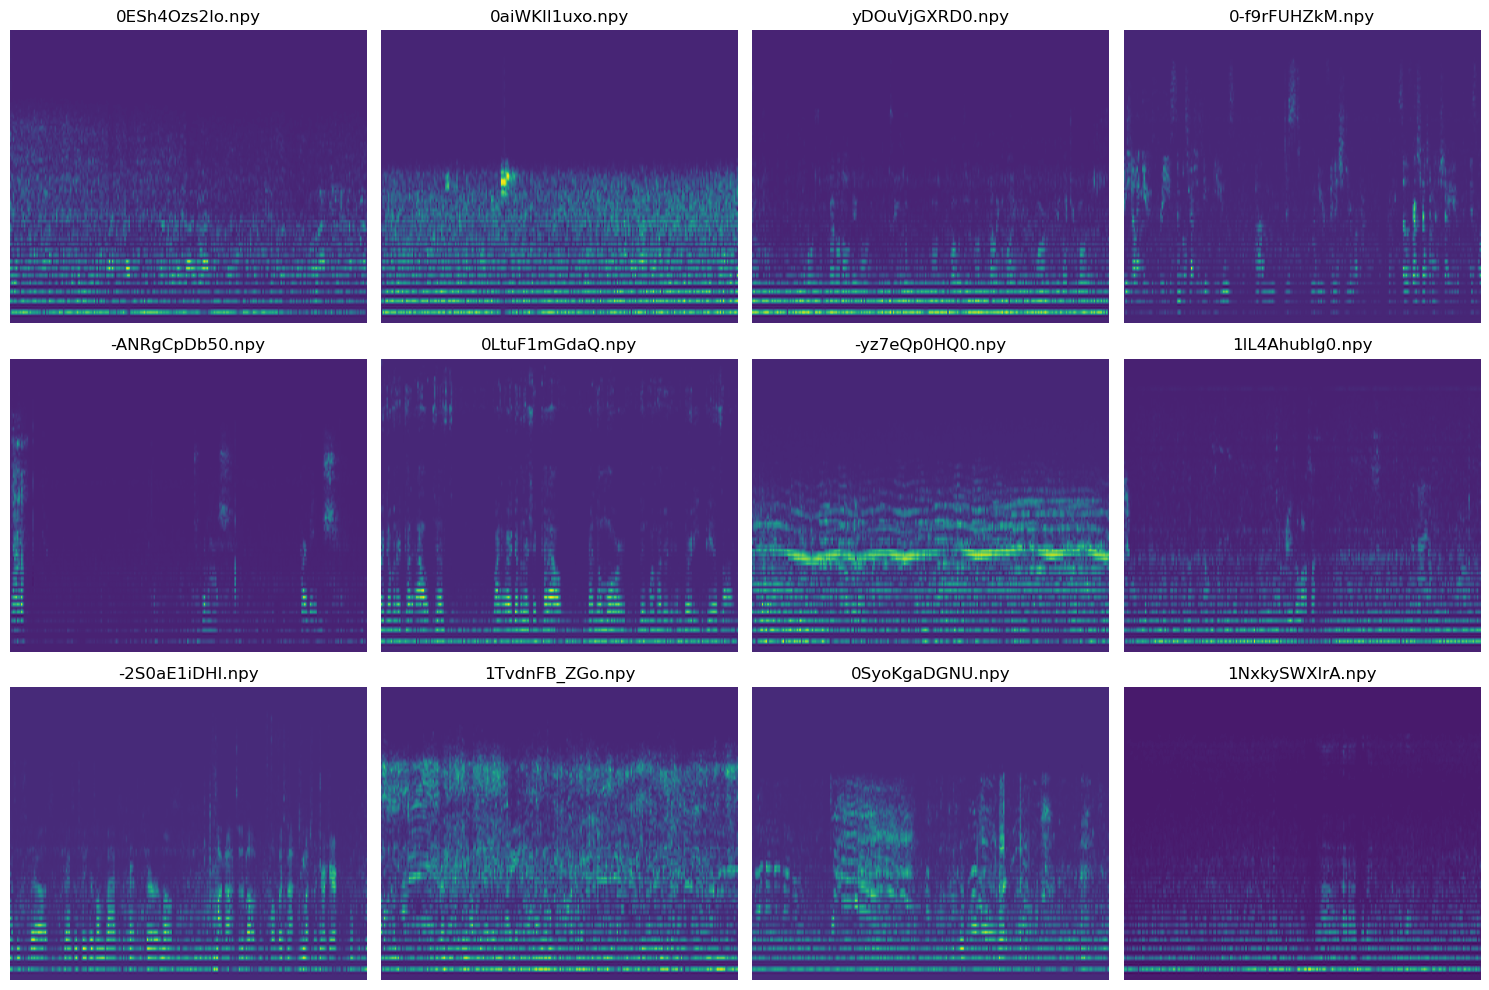

In [76]:
import os
import numpy as np
import random
import matplotlib.pyplot as plt

def load_random_npy_files(folder, num_files=12):
    """
    Load a specified number of random .npy files from a folder (including subfolders).

    Parameters:
        folder (str): Root folder to search for .npy files.
        num_files (int): Number of random .npy files to load.

    Returns:
        list of np.ndarray: Loaded spectrogram arrays.
        list of str: Corresponding file paths.
    """
    # Collect all .npy files in the folder and its subfolders
    npy_files = []
    for root, _, files in os.walk(folder):
        for file in files:
            if file.endswith('.npy'):
                npy_files.append(os.path.join(root, file))
    
    # Ensure there are enough files to choose from
    if len(npy_files) < num_files:
        raise ValueError(f"Only {len(npy_files)} .npy files found, but {num_files} are required.")

    # Randomly select the desired number of files
    selected_files = random.sample(npy_files, num_files)

    # Load the selected .npy files
    loaded_spectrograms = [np.load(file) for file in selected_files]
    return loaded_spectrograms, selected_files

def display_spectrograms(spectrograms, file_paths, grid_shape=(3, 4)):
    """
    Display spectrograms in a grid using Matplotlib.

    Parameters:
        spectrograms (list of np.ndarray): List of spectrogram arrays to display.
        file_paths (list of str): File paths corresponding to the spectrograms.
        grid_shape (tuple): Shape of the grid (rows, columns).
    """
    num_files = len(spectrograms)
    rows, cols = grid_shape

    plt.figure(figsize=(15, 10))
    for i, (spectrogram, file_path) in enumerate(zip(spectrograms, file_paths)):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(spectrogram, aspect='auto', origin='lower', cmap='viridis')
        plt.title(os.path.basename(file_path))
        plt.axis('off')

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Path to the folder containing .npy files
    folder_path = "../spects_trimmed_256/speech"  # Replace with your path

    # Load 12 random spectrograms
    try:
        spectrograms, file_paths = load_random_npy_files(folder_path, num_files=12)
        # Display the spectrograms
        display_spectrograms(spectrograms, file_paths, grid_shape=(3, 4))
    except ValueError as e:
        print(e)

## Napočítání statistik pro kontrolu dat

In [78]:
import os
import numpy as np
import random

def calculate_statistics_for_npy_files(folder_path, num_files=12):
    """
    Calculate statistics (min, max, median, average) for random .npy files.

    Parameters:
        folder_path (str): Path to the folder containing .npy files.
        num_files (int): Number of random .npy files to process.

    Returns:
        dict: Calculated statistics for the selected files.
    """
    # Collect all .npy files in the folder
    npy_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.npy')]
    
    # Ensure there are enough files to select from
    if len(npy_files) < num_files:
        raise ValueError(f"Only {len(npy_files)} files available, but {num_files} requested.")

    # Randomly select files
    selected_files = random.sample(npy_files, num_files)

    # Initialize lists to store statistics
    min_values, max_values, medians, averages = [], [], [], []

    # Process each file
    for file_path in selected_files:
        try:
            # Load the spectrogram
            spectrogram = np.load(file_path)
            
            # Calculate statistics
            min_values.append(np.min(spectrogram))
            max_values.append(np.max(spectrogram))
            medians.append(np.median(spectrogram))
            averages.append(np.mean(spectrogram))

            print(f"Processed: {file_path}")
        except Exception as e:
            print(f"Error processing {file_path}: {e}")

    # Combine results into a dictionary
    statistics = {
        "Min Values": min_values,
        "Max Values": max_values,
        "Medians": medians,
        "Averages": averages,
        "Overall Min": np.min(min_values),
        "Overall Max": np.max(max_values),
        "Overall Median": np.median(medians),
        "Overall Average": np.mean(averages),
    }

    return statistics


if __name__ == "__main__":
    # Path to the folder containing .npy files
    folder_path = "../spects_trimmed/music"  # Replace with your folder path

    # Calculate statistics for 12 random .npy files
    try:
        stats = calculate_statistics_for_npy_files(folder_path, num_files=12)
        
        # Print the results
        print("\n--- Statistics for 12 Random Spectrogram Files ---")
        for key, value in stats.items():
            print(f"{key}: {value}")

    except ValueError as e:
        print(e)


Processed: ../spects_trimmed/music/xeIHosUdHcI.npy
Processed: ../spects_trimmed/music/OH1HBs3StoU.npy
Processed: ../spects_trimmed/music/2aVEE3Ytn8w.npy
Processed: ../spects_trimmed/music/FlY6cmZo1cs.npy
Processed: ../spects_trimmed/music/KgdLV2l0jq4.npy
Processed: ../spects_trimmed/music/1MT8Gg0AKgg.npy
Processed: ../spects_trimmed/music/ciwHSyBpKjM.npy
Processed: ../spects_trimmed/music/sEs_iBXvEvY.npy
Processed: ../spects_trimmed/music/IFEa2iJyGP4.npy
Processed: ../spects_trimmed/music/Ks-EWnvPsYo.npy
Processed: ../spects_trimmed/music/PWShuUS4ehE.npy
Processed: ../spects_trimmed/music/h6mcqPbPrrE.npy

--- Statistics for 12 Random Spectrogram Files ---
Min Values: [-0.021071173, -0.034149434, -0.02713285, -0.031556968, -0.052439265, -0.035801224, -0.027023131, -0.03178665, -0.0102701485, -0.017550658, -0.018104313, -0.010173921]
Max Values: [0.96547586, 0.95617753, 1.010165, 0.96403974, 0.96734285, 0.9806868, 0.89388347, 0.94268465, 0.9258351, 0.81439555, 0.95473176, 0.6031388]
Medi

## Převedení spektogramu do .h5 podoby
- Pro snadnější processing jsou spektogramy převedeny do podoby .h5 file
- Kvůli limitům na přenos u colab jsou rozděleny do balanced chunků o požadovaném množství dat

In [79]:
import os
import numpy as np
import h5py

# --- Step 1: Define Paths and Predefined Labels ---
data_folder = "../spects_trimmed_256/"  # Root folder with spectrograms
output_folder = "../h5_results_fixed_256"  # Folder to save HDF5 chunks
os.makedirs(output_folder, exist_ok=True)  # Create the output folder if it doesn't exist

# Predefined set of labels (classes)
predefined_labels = ['engine', 'speech', 'music']
class_mapping = {label: idx for idx, label in enumerate(predefined_labels)}
print("Class Mapping:", class_mapping)

# --- Step 2: Load and Group Data ---
data_by_class = {label: [] for label in predefined_labels}

for class_name, label in class_mapping.items():
    class_folder = os.path.join(data_folder, class_name)
    if not os.path.exists(class_folder):
        print(f"Warning: Folder '{class_folder}' does not exist. Skipping...")
        continue

    print(f"Loading data for class '{class_name}'")
    for file in os.listdir(class_folder):
        if file.endswith(".npy"):
            file_path = os.path.join(class_folder, file)
            try:
                # Load the spectrogram
                spectrogram = np.load(file_path)

                # Append without modification
                if spectrogram.shape == (256, 256):
                    data_by_class[class_name].append((spectrogram, label))

            except Exception as e:
                print(f"Error reading {file_path}: {e}")

# --- Step 3: Save Data to HDF5 ---
chunk_count = 0
chunk_size_per_class = 1000

# Determine total chunks by the smallest non-zero class
total_samples_per_class = {label: len(data_by_class[label]) for label in predefined_labels}
print(f"Samples per class: {total_samples_per_class}")

# Calculate the minimum number of chunks we can create, allowing partial chunks
total_chunks = max(1, min((size + chunk_size_per_class - 1) // chunk_size_per_class 
                          for size in total_samples_per_class.values()))
print(f"Total balanced chunks that can be created: {total_chunks}")

for chunk_idx in range(total_chunks):
    spectrograms_chunk = []
    labels_chunk = []

    print(f"Creating chunk {chunk_idx + 1}...")
    for class_name, label in class_mapping.items():
        class_data = data_by_class[class_name]
        start_idx = chunk_idx * chunk_size_per_class
        end_idx = min(start_idx + chunk_size_per_class, len(class_data))

        # Extract data for this chunk
        spectrograms_chunk.extend([item[0] for item in class_data[start_idx:end_idx]])
        labels_chunk.extend([item[1] for item in class_data[start_idx:end_idx]])

    # Skip empty chunks
    if not spectrograms_chunk:
        continue

    # Convert to NumPy arrays
    spectrograms_chunk = np.array(spectrograms_chunk, dtype=np.float32)
    labels_chunk = np.array(labels_chunk, dtype=np.int32)

    # Save chunk to HDF5 file
    chunk_file = os.path.join(output_folder, f"chunk_{chunk_count}.h5")
    with h5py.File(chunk_file, "w") as hf:
        hf.create_dataset("spectrograms", data=spectrograms_chunk, dtype="float32")
        hf.create_dataset("labels", data=labels_chunk, dtype="int32")
        hf.attrs["class_mapping"] = str(class_mapping)

    print(f"Saved chunk: {chunk_file} with {len(spectrograms_chunk)} samples")
    chunk_count += 1

print(f"Finished creating {chunk_count} balanced chunks.")


Class Mapping: {'engine': 0, 'speech': 1, 'music': 2}
Loading data for class 'engine'
Loading data for class 'speech'
Loading data for class 'music'
Samples per class: {'engine': 861, 'speech': 860, 'music': 835}
Total balanced chunks that can be created: 1
Creating chunk 1...
Saved chunk: ../h5_results_fixed_256/chunk_0.h5 with 2556 samples
Finished creating 1 balanced chunks.


## Validace dat v h5

In [81]:
    import os
    import numpy as np
    import h5py
    
    def test_h5_values(file_path):
        """
        Test spectrogram values before saving to HDF5 and after reading back.
    
        Parameters:
            file_path (str): Path to the input .npy file.
    
        Prints:
            - Min, Max, Mean, Median values before saving.
            - Min, Max, Mean, Median values after reading from HDF5.
        """
        # Step 1: Load the spectrogram from the .npy file
        try:
            spectrogram = np.load(file_path)
            print(f"Before Saving to HDF5:")
            print(f"  Min: {np.min(spectrogram):.6f}, Max: {np.max(spectrogram):.6f}, "
                  f"Mean: {np.mean(spectrogram):.6f}, Median: {np.median(spectrogram):.6f}")
        except Exception as e:
            print(f"Error loading file {file_path}: {e}")
            return
    
        # Step 2: Save the spectrogram to a temporary HDF5 file
        temp_h5_file = "temp_test.h5"
        try:
            with h5py.File(temp_h5_file, "w") as hf:
                hf.create_dataset("spectrograms", data=spectrogram, dtype="float32")
        except Exception as e:
            print(f"Error saving spectrogram to HDF5: {e}")
            return
    
        # Step 3: Read the spectrogram back from the HDF5 file
        try:
            with h5py.File(temp_h5_file, "r") as hf:
                loaded_spectrogram = hf["spectrograms"][:]
                print(f"\nAfter Reading from HDF5:")
                print(f"  Min: {np.min(loaded_spectrogram):.6f}, Max: {np.max(loaded_spectrogram):.6f}, "
                      f"Mean: {np.mean(loaded_spectrogram):.6f}, Median: {np.median(loaded_spectrogram):.6f}")
        except Exception as e:
            print(f"Error reading from HDF5: {e}")
            return
    
        # Optional: Clean up the temporary file
        if os.path.exists(temp_h5_file):
            os.remove(temp_h5_file)
            print("\nTemporary HDF5 file removed.")
    
    if __name__ == "__main__":
        # Input file path
        file_path = "../spects_trimmed_256/engine/0FN_1SJqtaw.npy"  # Replace with your file path
    
        # Test values before and after HDF5
        test_h5_values(file_path)


Before Saving to HDF5:
  Min: -0.112985, Max: 0.961161, Mean: 0.028423, Median: 0.001344

After Reading from HDF5:
  Min: -0.112985, Max: 0.961161, Mean: 0.028423, Median: 0.001344

Temporary HDF5 file removed.


## Oprava případných NaN v file

In [82]:
import os
import numpy as np
import h5py

def check_and_fix_h5_file(file_path, fix_nans=False):
    """
    Check an entire HDF5 file for NaN values, count them, and optionally fix them.

    Parameters:
        file_path (str): Path to the HDF5 file.
        fix_nans (bool): If True, replaces NaN values with 0 and updates the HDF5 file.

    Prints:
        - Total NaN counts for each dataset.
        - Summary of overall NaN counts.
    """
    print(f"Checking file: {file_path}")
    total_nan_count = 0

    try:
        # Open the HDF5 file in read/write mode if fixing is enabled
        mode = "r+" if fix_nans else "r"
        with h5py.File(file_path, mode) as hf:
            for dataset_name in hf.keys():
                print(f"Processing dataset: {dataset_name}")
                data = hf[dataset_name][:]
                
                # Count NaN values
                nan_count = np.isnan(data).sum()
                total_nan_count += nan_count
                print(f"  NaN Count: {nan_count}")

                # Fix NaN values if needed
                if fix_nans and nan_count > 0:
                    print(f"  Fixing NaN values in dataset: {dataset_name}")
                    data_fixed = np.nan_to_num(data, nan=0.0, posinf=0.0, neginf=0.0)
                    hf[dataset_name][...] = data_fixed  # Overwrite the dataset with fixed data

    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
        return

    # Summary of NaN counts
    if total_nan_count > 0:
        print(f"\nTotal NaN values found in file '{file_path}': {total_nan_count}")
        if fix_nans:
            print("All NaN values have been replaced with 0.")
    else:
        print(f"\nNo NaN values found in file '{file_path}'.")

if __name__ == "__main__":
    # Path to the HDF5 file
    h5_file_path = "../h5_results_fixed_256/chunk_0.h5"  # Replace with your HDF5 file path

    # Check the HDF5 file for NaNs (set fix_nans=True to fix them)
    check_and_fix_h5_file(h5_file_path, fix_nans=True)

Checking file: ../h5_results_fixed_256/chunk_0.h5
Processing dataset: labels
  NaN Count: 0
Processing dataset: spectrograms
  NaN Count: 65536
  Fixing NaN values in dataset: spectrograms

Total NaN values found in file '../h5_results_fixed_256/chunk_0.h5': 65536
All NaN values have been replaced with 0.


## Kontrola hodnot v h5 file 

In [83]:
import numpy as np
import h5py

def calculate_statistics_from_h5_file(h5_file_path):
    """
    Calculate overall statistics (min, max, median, average) for all spectrograms in an HDF5 file.

    Parameters:
        h5_file_path (str): Path to the HDF5 file.

    Returns:
        dict: Overall statistics including min, max, median, and average.
    """
    overall_min = float('inf')
    overall_max = float('-inf')
    all_medians = []
    total_sum = 0.0
    total_count = 0

    print(f"Processing: {h5_file_path}")
    try:
        with h5py.File(h5_file_path, "r") as hf:
            # Load spectrogram data
            spectrograms = hf["spectrograms"][:]  # Load all spectrograms at once
            
            # Update statistics
            overall_min = np.min(spectrograms)
            overall_max = np.max(spectrograms)
            all_medians.append(np.median(spectrograms))
            total_sum = np.sum(spectrograms)
            total_count = spectrograms.size

    except Exception as e:
        print(f"Error processing {h5_file_path}: {e}")
        return None

    # Compute overall statistics
    overall_average = total_sum / total_count
    overall_median = np.median(all_medians)

    # Combine results into a dictionary
    statistics = {
        "Overall Min": overall_min,
        "Overall Max": overall_max,
        "Overall Median": overall_median,
        "Overall Average": overall_average,
    }

    return statistics


if __name__ == "__main__":
    # Path to the HDF5 file
    h5_file_path = "../h5_results_fixed/chunk_0.h5"  # Replace with your HDF5 file path

    # Calculate overall statistics
    stats = calculate_statistics_from_h5_file(h5_file_path)

    # Print the results
    if stats:
        print("\n--- Overall Statistics for Spectrograms in HDF5 File ---")
        for key, value in stats.items():
            print(f"{key}: {value}")

Processing: ../h5_results_fixed/chunk_0.h5

--- Overall Statistics for Spectrograms in HDF5 File ---
Overall Min: -0.1147308424115181
Overall Max: 1.0932166576385498
Overall Median: 0.0029909610748291016
Overall Average: 0.07045575113550225
